In [1]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import KFold
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load Fashion-MNIST Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data, abgerufen 14.Juli 2021
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0 - 0.5
x_test = x_test / 255.0 - 0.5

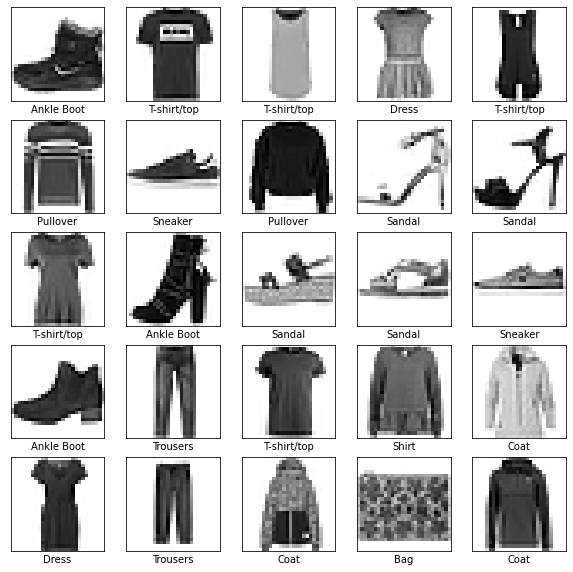

In [3]:
class_names = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py, abgerufen 14.Juli 2021

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#print(train_labels.shape)
y_train = y_train.reshape(y_train.shape[0], 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

y_test = y_test.reshape(y_test.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [4]:
#Create and Train the Base Model with Fashion MNIST
#Quelle
#Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
#https://www.tensorflow.org/guide/keras/sequential_model, abgerufen 14.Juli 2021
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(200,activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(200,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

model.summary()

#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint, abgerufen 14.Juli 2021

checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Quelle
#https://www.tensorflow.org/guide/keras/train_and_evaluate, abgerufen 14.Juli 2021

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Epoch 46/50
469/469 [==============================] - 4s 9ms/step - loss: 0.3723 - accuracy: 0.8807 - val_loss: 0.3991 - val_accuracy: 0.8702
Epoch 47/50
469/469 [==============================] - 4s 9ms/step - loss: 0.3737 - accuracy: 0.8799 - val_loss: 0.4055 - val_accuracy: 0.8614
Epoch 48/50
469/469 [==============================] - 4s 9ms/step - loss: 0.3600 - accuracy: 0.8821 - val_loss: 0.3744 - val_accuracy: 0.8771
Epoch 49/50
469/469 [==============================] - 4s 9ms/step - loss: 0.3897 - accuracy: 0.8754 - val_loss: 0.4216 - val_accuracy: 0.8591
Epoch 50/50
469/469 [==============================] - 4s 9ms/step - loss: 0.5177 - accuracy: 0.8363 - val_loss: 0.4951 - val_accuracy: 0.8315


In [5]:
# Save the entire model for Transfer Learning
!mkdir -p saved_models_fashion_mnist
model.save('saved_models_fashion_mnist/base_model_fashion_mnist')

INFO:tensorflow:Assets written to: saved_models_fashion_mnist/base_model_fashion_mnist/assets


In [6]:
def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

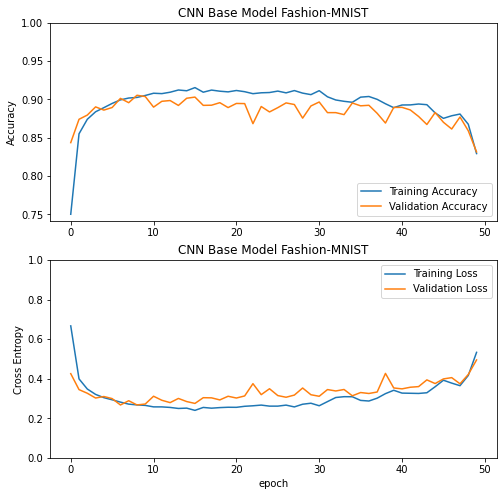

In [7]:
# Display training curve 
display_history(history, "CNN Base Model Fashion-MNIST")

3


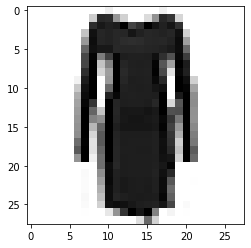

In [8]:
y=model.predict(x_test)
print(np.argmax(y[1500]))
plt.imshow(x_test[1500], cmap=plt.cm.binary)

In [9]:
# Evaluate model accuracy
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print('Accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(x_test).shape)

313/313 - 1s - loss: 0.2674 - accuracy: 0.9055
Accuracy: 90.55%
(10000, 10)


<h2>Transfer Learning

In [10]:
# Load the Model for Transfer Learning
new_model = tf.keras.models.load_model('saved_models_fashion_mnist/base_model_fashion_mnist')

#Freeze the layers on the model
new_model.trainable = False

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [11]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(x_test).shape)

313/313 - 1s - loss: 0.2674 - accuracy: 0.9055
Restored model, accuracy: 90.55%
(10000, 10)


In [2]:
#Load MNIST Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data, abgerufen 14.Juli 2021
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

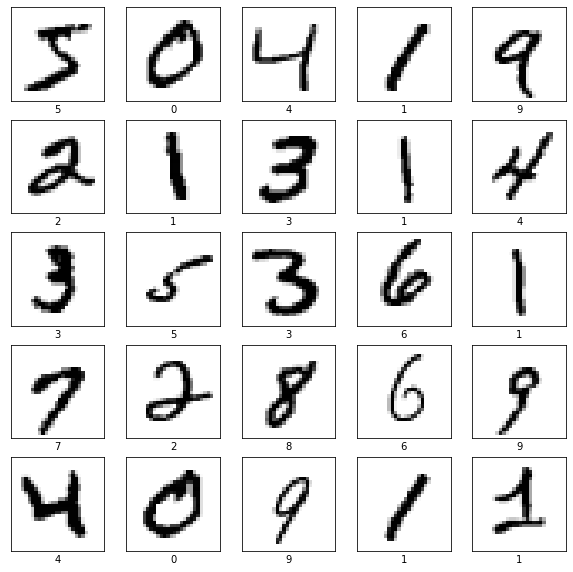

In [3]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0 -0.5
x_test = x_test / 255.0 - 0.5

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py, abgerufen 14.Juli 2021

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

y_train = y_train.reshape(y_train.shape[0], 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

y_test = y_test.reshape(y_test.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

#inputs and targets for kFold training set
inputs = x_train
targets = y_train

<h2>Add a classifier head</h2>

Create a new model by adding a classifier on top of the base model.

In [14]:
def build_mnist_model(base_model):
  model = tf.keras.models.Sequential()
  for layer in base_model.layers[:-4]:
        layer.trainable = False
        model.add(layer)
        print('Layer ' + layer.name + ' frozen.')
  model.add(tf.keras.layers.Dense(200,activation='relu')),
  model.add(tf.keras.layers.Dropout(rate=0.5)),
  model.add(tf.keras.layers.Dense(200,activation='relu')),
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

In [16]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold, abgerufen 14.Juli 2021
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for MNIST 7-9
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model, abgerufen 14.Juli 2021
    transfer_model = build_mnist_model(new_model)
       
    transfer_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint, abgerufen 14.Juli 2021
    
    checkpoint_filepath = f'tmp/tl_checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate, abgerufen 14.Juli 2021
    #Transfer Learning of the Model with MNIST Dataset 7-9
    history = transfer_model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback]
    )

    # Generate generalization metrics
    scores = transfer_model.evaluate(inputs[test], targets[test], verbose=0)
    print(transfer_model.metrics_names)
    print(f'Score for fold {fold_no}: {transfer_model.metrics_names[0]} of {scores[0]}; {transfer_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    transfer_model.save(f'saved_models_mnist_kfold/tl_model_mnist_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.
Layer conv2d_3 frozen.
Layer max_pooling2d_1 frozen.
Layer flatten frozen.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 0.4663 - accuracy: 0.8508 - val_loss: 0.1821 - val_accuracy: 0.9408
Epoch 2/50
422/422 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9494 - val_loss: 0.1109 - val_accuracy: 0.9680
Epoch 3/50
422/422 [==============================] - 2s 5ms/step - loss: 0.1333 - accuracy: 0.9587 - val_loss: 0.1006 - val_accuracy: 0.9705
Epoch 4/50
422/422 [==============================] - 2s 5ms/step - loss: 0.1194 - accuracy: 0.9665 - val_loss: 0.1070 - val_accuracy: 0.9675
Epoch 5/50
422/422 [==============================] - 2s 5ms/step - loss: 0.1105 - accuracy: 0.9674 - val_loss: 0.0932 - val_accuracy: 0.9715
Epoch 6/50
422/422 [===

422/422 [==============================] - 3s 6ms/step - loss: 0.0918 - accuracy: 0.9730 - val_loss: 0.0820 - val_accuracy: 0.9772
Epoch 8/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0846 - accuracy: 0.9740 - val_loss: 0.0807 - val_accuracy: 0.9760
Epoch 9/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0784 - accuracy: 0.9769 - val_loss: 0.0777 - val_accuracy: 0.9757
Epoch 10/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.0758 - val_accuracy: 0.9765
Epoch 11/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0711 - accuracy: 0.9784 - val_loss: 0.0815 - val_accuracy: 0.9755
Epoch 12/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0728 - accuracy: 0.9784 - val_loss: 0.0810 - val_accuracy: 0.9777
Epoch 13/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0663 - accuracy: 0.9795 - val_loss: 0.0834 - val_accuracy: 0.9763
Epoch 14/50
4

422/422 [==============================] - 3s 6ms/step - loss: 0.0644 - accuracy: 0.9799 - val_loss: 0.0921 - val_accuracy: 0.9800
Epoch 16/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0576 - accuracy: 0.9823 - val_loss: 0.0915 - val_accuracy: 0.9777
Epoch 17/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0574 - accuracy: 0.9820 - val_loss: 0.0878 - val_accuracy: 0.9787
Epoch 18/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0528 - accuracy: 0.9843 - val_loss: 0.0854 - val_accuracy: 0.9792
Epoch 19/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0612 - accuracy: 0.9827 - val_loss: 0.0785 - val_accuracy: 0.9817
Epoch 20/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0486 - accuracy: 0.9858 - val_loss: 0.0802 - val_accuracy: 0.9788
Epoch 21/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0559 - accuracy: 0.9836 - val_loss: 0.0811 - val_accuracy: 0.9803
Epoch 22/50

422/422 [==============================] - 3s 6ms/step - loss: 0.0521 - accuracy: 0.9840 - val_loss: 0.0773 - val_accuracy: 0.9782
Epoch 24/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0470 - accuracy: 0.9860 - val_loss: 0.0874 - val_accuracy: 0.9765
Epoch 25/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.0775 - val_accuracy: 0.9785
Epoch 26/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0794 - val_accuracy: 0.9777
Epoch 27/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.0830 - val_accuracy: 0.9800
Epoch 28/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0439 - accuracy: 0.9866 - val_loss: 0.0863 - val_accuracy: 0.9770
Epoch 29/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0470 - accuracy: 0.9861 - val_loss: 0.0848 - val_accuracy: 0.9785
Epoch 30/50

422/422 [==============================] - 3s 6ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0741 - val_accuracy: 0.9808
Epoch 32/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0449 - accuracy: 0.9862 - val_loss: 0.0659 - val_accuracy: 0.9838
Epoch 33/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0679 - val_accuracy: 0.9827
Epoch 34/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0731 - val_accuracy: 0.9810
Epoch 35/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 0.0800 - val_accuracy: 0.9803
Epoch 36/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0395 - accuracy: 0.9893 - val_loss: 0.0750 - val_accuracy: 0.9830
Epoch 37/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.0763 - val_accuracy: 0.9827
Epoch 38/50

In [18]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_mnist_kfold/tl_model_mnist_{i}')
    model.load_weights(f'tmp/tl_checkpoint{i}')

    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('tl_accuracy.xlsx', sheet_name='kfold', index=False)

313/313 - 1s - loss: 0.0753 - accuracy: 0.9810
Accuracy: 98.10%
(10000, 10)
313/313 - 1s - loss: 0.0732 - accuracy: 0.9805
Accuracy: 98.05%
(10000, 10)
313/313 - 1s - loss: 0.0759 - accuracy: 0.9817
Accuracy: 98.17%
(10000, 10)
313/313 - 1s - loss: 0.0683 - accuracy: 0.9817
Accuracy: 98.17%
(10000, 10)
313/313 - 1s - loss: 0.0759 - accuracy: 0.9822
Accuracy: 98.22%
(10000, 10)
313/313 - 1s - loss: 0.0698 - accuracy: 0.9810
Accuracy: 98.10%
(10000, 10)
313/313 - 1s - loss: 0.0711 - accuracy: 0.9822
Accuracy: 98.22%
(10000, 10)
313/313 - 1s - loss: 0.0665 - accuracy: 0.9825
Accuracy: 98.25%
(10000, 10)
313/313 - 1s - loss: 0.0674 - accuracy: 0.9819
Accuracy: 98.19%
(10000, 10)
313/313 - 1s - loss: 0.0777 - accuracy: 0.9819
Accuracy: 98.19%
(10000, 10)


In [ ]:
# Display training curve 
display_history(history, "CNN Model MNIST after Transfer Learning")

<h2> Fine Tuning

In [4]:
#Load Model for fine tuning and attacking
fine_tune_model = tf.keras.models.load_model(f'saved_models_mnist_kfold/tl_model_mnist_10')
fine_tune_model.load_weights(f'tmp/tl_checkpoint10')

In [5]:
#Unfreeze all Layers und base model
fine_tune_model.trainable = True

In [6]:
#Print number of layers of model
print('Number of layers in the base model: ', len(fine_tune_model.layers))

Number of layers in the base model:  11


In [7]:
#Quelle
#https://github.com/PacktPublishing/Hands-On-Transfer-Learning-with-TensorFlow-2.0-Video, abgerufen 14.Juli 2021
#fine tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in fine_tune_model.layers[:fine_tune_at]:
  layer.trainable =  False
  print('Layer ' + layer.name + ' frozen.')  

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.


In [8]:
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [9]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Fine Tuning of the Model with MNIST Dataset
history_fine = fine_tune_model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback]
)

fine_tune_model.load_weights(checkpoint_filepath)

Epoch 1/50
469/469 [==============================] - 4s 7ms/step - loss: 0.0678 - accuracy: 0.9819 - val_loss: 0.0936 - val_accuracy: 0.9741
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0494 - accuracy: 0.9846 - val_loss: 0.0666 - val_accuracy: 0.9832
Epoch 3/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.0662 - val_accuracy: 0.9834
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.0591 - val_accuracy: 0.9848
Epoch 5/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0602 - val_accuracy: 0.9851
Epoch 6/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0608 - val_accuracy: 0.9856
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.0589 - val_accuracy: 0.9855
Epoch 

In [ ]:
# Display training curve 
display_history(history_fine, "CNN Model MNIST after Fine Tuning")

In [10]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/, abgerufen 14.Juli 2021
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [11]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox, abgerufen 14.Juli 2021
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(fine_tune_model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test, dtype='int64')
attack_labels = tf.reshape(attack_labels, 10000)
attack_images = tf.convert_to_tensor(x_test, dtype='float32')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [13]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox, abgerufen 14.Juli 2021
predictions = fine_tune_model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Clean Accuracy:  98.85 %


In [14]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html, abgerufen 14.Juli 2021
#PGD40 mit 20 Restarts
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 20)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [16]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Scikit Learn: ' + sklearn.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)

Versionsinformationen der Module:
/home/fabian/anaconda3/envs/tf-gpu2/bin/python
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
conda 4.10.1
Python 3.8.5
Tensorflow: 2.4.1
Tensorflow Datasets: 3.1.0
Scikit Learn: 0.24.2
Eagerpy: 0.29.0
Numpy: 1.20.2
Matplotlib: 3.4.1
Foolbox: 3.3.1
Pandas: 1.2.4
